In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
IMAGE_LEN = 224
IMAGE_SIZE = (IMAGE_LEN, IMAGE_LEN)
BATCH_SIZE = 32

"/content/drive/MyDrive/dataset",

('/content/drive/MyDrive/dataset',)

In [ ]:
#number of total images

import os

dataset_path = "/content/drive/MyDrive/dataset"
image_count = 0

for root, dirs, files in os.walk("/content/drive/MyDrive/dataset"):
  for file in files:
    if file.lower().endswith(('.png', '.jpg', '.jpeg','.gif')):
      image_count += 1

print("Total number of images:", image_count)

Total number of images: 1400


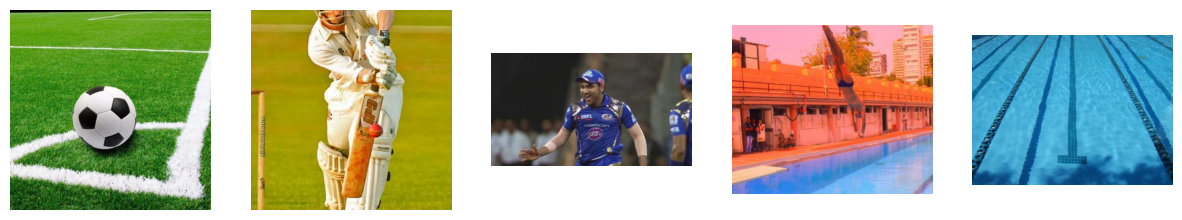

In [ ]:
# show sample images before preprocessing

import matplotlib.pyplot as plt
import os
import random

dataset_path = "/content/drive/MyDrive/dataset"

def show_sample_images(dataset_path, num_images=5):
  """Shows sample images from the dataset."""

  image_files = []
  for root, dirs, files in os.walk(dataset_path):
    for file in files:
      if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
        image_files.append(os.path.join(root, file))

  if not image_files:
    print("No image files found in the dataset.")
    return

  random_image_files = random.sample(image_files, min(num_images, len(image_files)))

  plt.figure(figsize=(15, 5))
  for i, image_file in enumerate(random_image_files):
    img = PIL.Image.open(image_file)
    plt.subplot(1, num_images, i + 1)
    plt.imshow(img)
    plt.axis('off')
  plt.show()


show_sample_images(dataset_path)

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
"/content/drive/MyDrive/dataset",
validation_split=0.2,
subset="training",
label_mode = "categorical",
seed=1005,
image_size=IMAGE_SIZE,
batch_size=BATCH_SIZE)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
"/content/drive/MyDrive/dataset",
validation_split=0.2,
subset="validation",
label_mode = "categorical",
seed=1005,
image_size=IMAGE_SIZE,
batch_size=BATCH_SIZE)
#store class names
class_names = train_ds.class_names

Found 1400 files belonging to 7 classes.
Using 1120 files for training.
Found 1400 files belonging to 7 classes.
Using 280 files for validation.


In [ ]:
# Analyze image sizes (width, height)

import tensorflow as tf  # Import TensorFlow
import numpy as np

def analyze_image_sizes(dataset):
    """Analyzes image sizes (width, height) in a TensorFlow Dataset.

    Args:
        dataset: A TensorFlow Dataset containing images.

    Returns:
        A tuple containing:
            min_width: The minimum image width.
            max_width: The maximum image width.
            min_height: The minimum image height.
            max_height: The maximum image height.
            avg_width: The average image width.
            avg_height: The average image height.
    """
    widths = []
    heights = []

    for images, _ in dataset:  # Iterate through batches of images and labels
        for image in images:  # Iterate through individual images in a batch
            width = tf.shape(image)[1]  # Get image width
            height = tf.shape(image)[0]  # Get image height
            widths.append(width.numpy())  # Append width to list
            heights.append(height.numpy())  # Append height to list

    min_width = np.min(widths)
    max_width = np.max(widths)
    min_height = np.min(heights)
    max_height = np.max(heights)
    avg_width = np.mean(widths)
    avg_height = np.mean(heights)

    return min_width, max_width, min_height, max_height, avg_width, avg_height

# Recreate the train_ds Dataset to make it available in this scope:
IMAGE_LEN = 224
IMAGE_SIZE = (IMAGE_LEN, IMAGE_LEN)
BATCH_SIZE = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/dataset",
    validation_split=0.2,
    subset="training",
    label_mode="categorical",
    seed=1005,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)


min_width, max_width, min_height, max_height, avg_width, avg_height = analyze_image_sizes(train_ds)

print(f"Minimum Width: {min_width}")
print(f"Maximum Width: {max_width}")
print(f"Minimum Height: {min_height}")
print(f"Maximum Height: {max_height}")
print(f"Average Width: {avg_width}")
print(f"Average Height: {avg_height}")

Found 1400 files belonging to 7 classes.
Using 1120 files for training.
Minimum Width: 224
Maximum Width: 224
Minimum Height: 224
Maximum Height: 224
Average Width: 224.0
Average Height: 224.0


In [ ]:
#Analyze image pixel values (brightness, contrast)

import numpy as np

def analyze_image_pixel_values(dataset):
  """Analyzes image pixel values (brightness and contrast) in a dataset.

  Args:
    dataset: A TensorFlow Dataset containing images.

  Returns:
    A tuple containing the average brightness and contrast of the images.
  """

  brightness_values = []
  contrast_values = []

  for images, _ in dataset:
    for image in images:
      # Convert the image to a NumPy array
      image_np = image.numpy()

      # Calculate brightness (average pixel intensity)
      brightness = np.mean(image_np)
      brightness_values.append(brightness)

      # Calculate contrast (standard deviation of pixel intensities)
      contrast = np.std(image_np)
      contrast_values.append(contrast)

  # Calculate average brightness and contrast across all images
  avg_brightness = np.mean(brightness_values)
  avg_contrast = np.mean(contrast_values)

  return avg_brightness, avg_contrast

# Analyze pixel values in the training dataset
avg_brightness, avg_contrast = analyze_image_pixel_values(train_ds)

print(f"Average Brightness: {avg_brightness}")
print(f"Average Contrast: {avg_contrast}")


Average Brightness: 110.93428802490234
Average Contrast: 63.52241134643555


Visualize Training Data

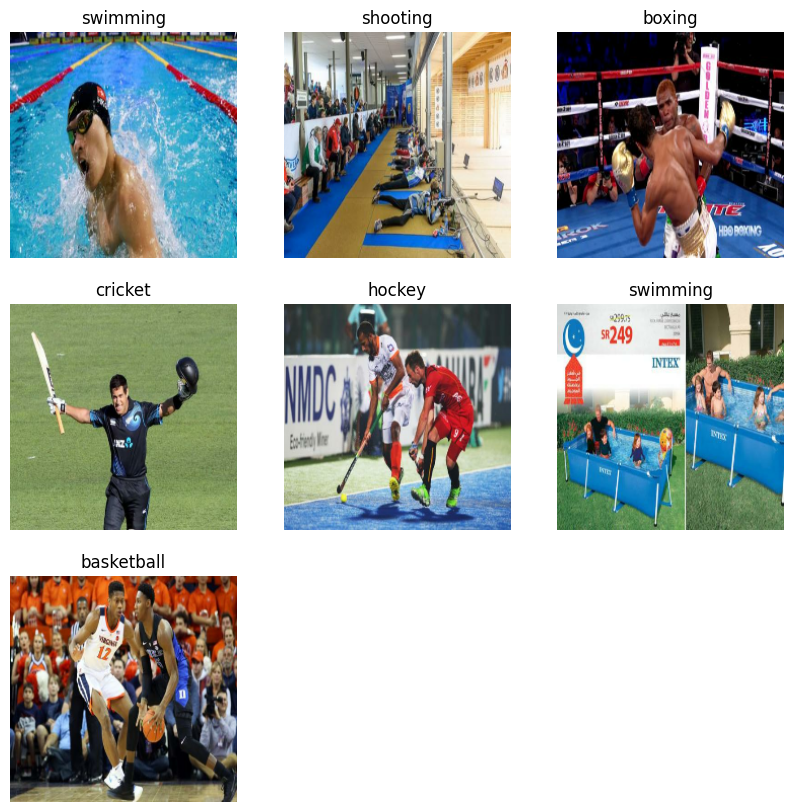

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(7):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

Basic CNN
The first two layers we are using are responsible for rescaling and data augmentation. Within the data augmentation layer, we are using a horizontal flip and a random zoom. The augmentation ensures that the training data is reshaped and re-fed into the model, thus increasing the number of examples our model is learning on. Ultimately, this helps the model generalize better.

For the learning itself, our model has 3 Convolution layers, each followed by a Max Pool layer. After 3 sets of convolution layers, we incorporate a dropout layer, a dense layer with 128 neurons, and finally a dense layer with 8 neurons - which correspond to the 8 sports that we want to predict. Kindly note that we will be using the relu activation throughout.

In [ ]:
#prefetch data to speed up training
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# Import preprocessing layers from tf.keras.layers directly
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, Rescaling



data_augmentation = keras.Sequential(
    [
        RandomFlip("horizontal"),
        RandomZoom(0.10),
    ]
)


# Assuming class_names was defined previously (e.g., from image_dataset_from_directory)
num_classes = len(class_names)  # Get the number of classes from class_names


from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling

model = Sequential([
tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
# Use Rescaling directly from tf.keras.layers
layers.Rescaling(1./255),
data_augmentation,
layers.Conv2D(16, 3, padding='same', activation='relu'),
layers.MaxPooling2D(),

layers.Conv2D(32, 3, padding='same', activation='relu'),
layers.MaxPooling2D(),
layers.Conv2D(64, 3, padding='same', activation='relu'),
layers.MaxPooling2D(),


layers.Dropout(0.2),
layers.Flatten(),
layers.Dense(256, activation='relu'),
layers.Dense(num_classes)
])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      12,845,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,870,695 (49.10 MB)

 Trainable params: 12,870,695 (49.10 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# prompt: code to train the data

epochs = 20  # You can adjust the number of epochs as needed
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.1951 - loss: 1.9021 - val_accuracy: 0.2964 - val_loss: 1.6686
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.3468 - loss: 1.6687 - val_accuracy: 0.4143 - val_loss: 1.6486
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.3799 - loss: 1.6861 - val_accuracy: 0.5393 - val_loss: 1.4878
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.5324 - loss: 1.4287 - val_accuracy: 0.5786 - val_loss: 1.3718
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.5400 - loss: 1.3752 - val_accuracy: 0.6179 - val_loss: 1.3140
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.6367 - loss: 1.2530 - val_accuracy: 0.5536 - val_loss: 1.3659
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.6379 - loss: 1.2410 - val_accuracy: 0.6036 - val_loss: 1.2959
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.6751 - loss: 1.1742 - val_accuracy: 0.5929 - val_loss:

Predicting on Test Data

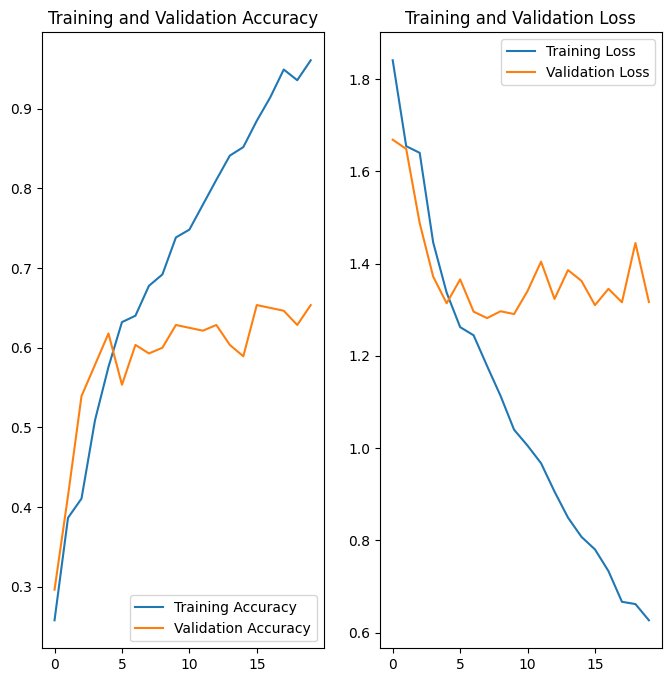

In [ ]:
# training accuracy and testing accuracy

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
print("Training Accuracy:", acc[-1])  # Print the final training accuracy
print("Validation Accuracy:", val_acc[-1])

Training Accuracy: 0.9607142806053162
Validation Accuracy: 0.6535714268684387


In [ ]:
testSet = tf.keras.preprocessing.image_dataset_from_directory(
"/content/drive/MyDrive/dataset",
shuffle=True,
label_mode = "categorical",
image_size=IMAGE_SIZE,
batch_size=BATCH_SIZE)


Found 1400 files belonging to 7 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step


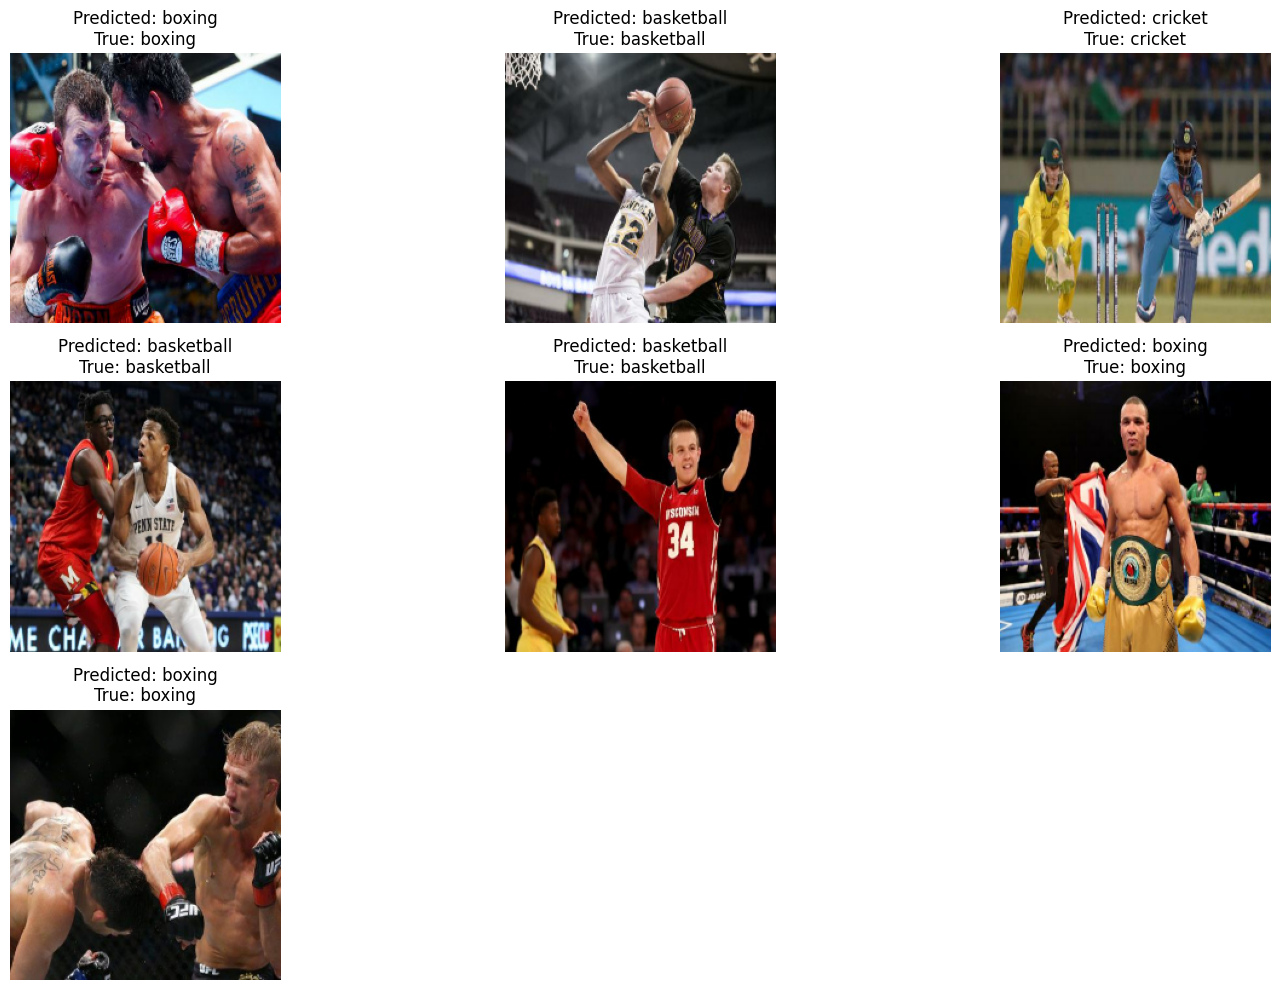

In [ ]:
#prediction

plt.figure(figsize=(15, 10))

for images, labels in testSet.take(1):  # Take one batch of images and labels
    predictions = model.predict(images)
    for i in range(7):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_label = class_names[np.argmax(predictions[i])]
        true_label = class_names[np.argmax(labels[i])]

        plt.title(f"Predicted: {predicted_label}\nTrue: {true_label}")
        plt.axis("off")

plt.tight_layout()
plt.show()